### Wire cutting as a method to improve performance of quantum circuits

Circuit-knitting is an umbrella term which encapsulates various methods of partitioning a circuit in multiple smaller subcircuits involving fewer gates and/or qubits. Each of the subcircuits can be executed independently and the final result is obtained via some classical postprocessing over the outcome of each subcircuit.

This notebook deals with a method called <b>wire cutting</b> where the circuit is partitioned along the wire [1,2]. Note that, partitioning is simple in classical circuits since the outcome at the point of partition can be determined deterministically, and is either 0 or 1. However, the state of the qubit at the point of the cut is, in general, a mixed state. Therefore, each subcircuit needs to be measured multiple times in different basis (usually a tomographically complete set of basis such as the Pauli basis [3,4]) and correspondingly prepared in its eigenstate. The Figure below (<i>courtesy: PhD Thesis, Ritajit Majumdar</i>) shows an example of wire cutting for a 4-qubit GHZ state into three subcircuits. Here $M_j$ denote a set of basis (usually Pauli X, Y and Z) and $P_i$ denote a set of eigenstates (usually $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|+i\rangle$).

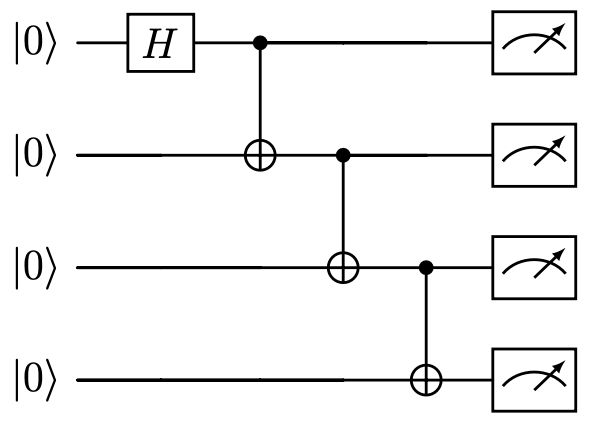
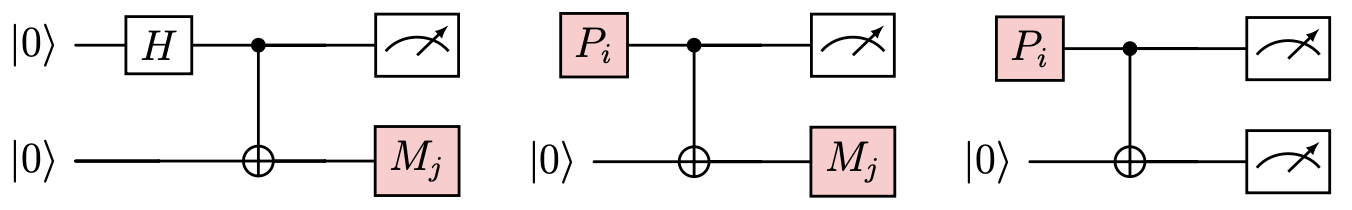

Since each subcircuit has fewer qubits and/or gates, they are expected to be less amenable to noise. This notebook shows an example where this method can be used to effectively suppress the noise in the system.

### Start

We shall take a $p=2$ QAOA circuit as an example for this notebook.

### Build

Here we show the function to build a QAOA circuit, and assign parameters to it. Initial parameters are assigned randomly.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy.random import default_rng
from numpy import pi

def build_qaoa_circuit(
    num_qubits: int,
    depth: int, # here the convention is depth=2*p
    ):
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    return circuit

def produce_qaoa_parameters(num_layers, seed=None):
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()

    params = []
    for idx in range(len(betas)):
        params.append(gammas[idx])
        params.append(betas[idx])
    return params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Here we show an example of a 20 qubit $p=2$ QAOA circuit.

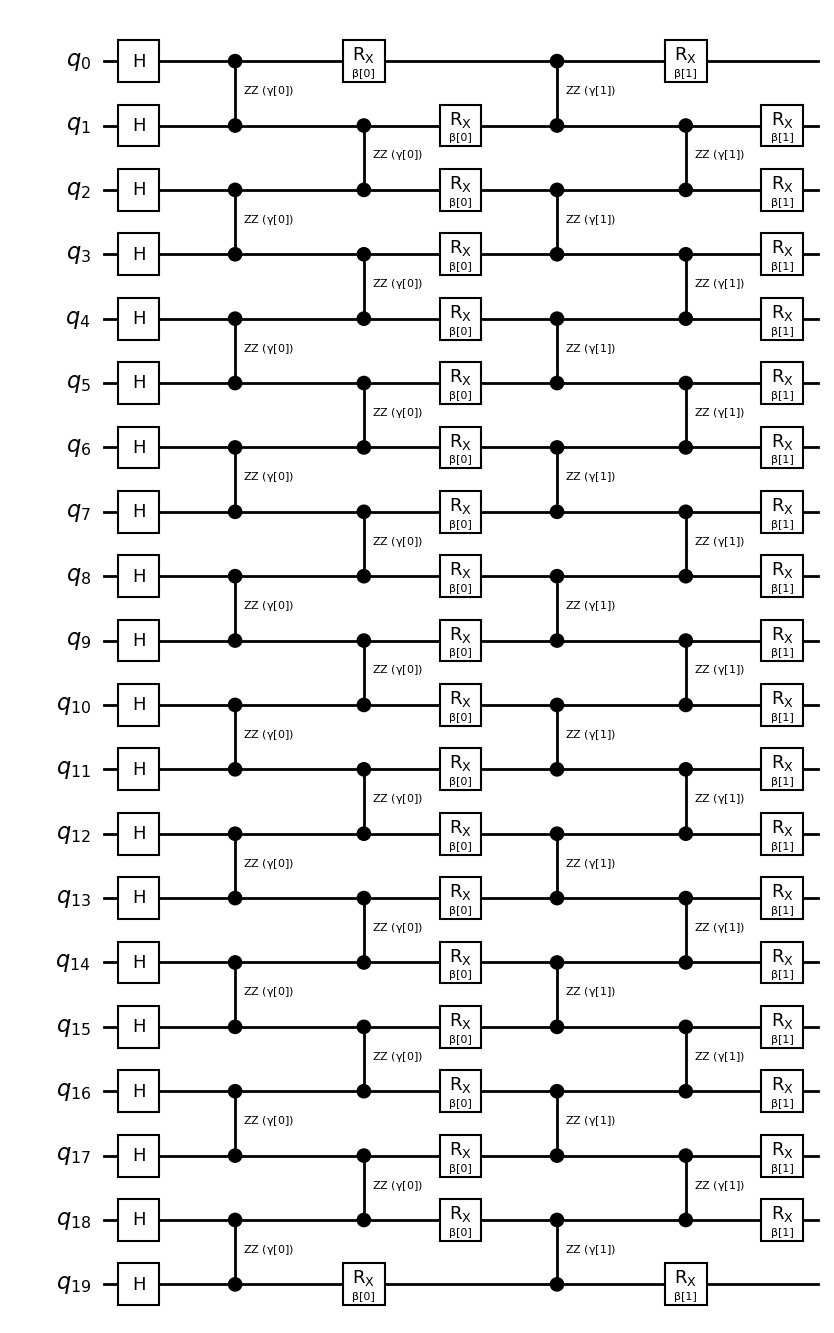

In [2]:
num_qubits = 20
p = 2
qaoa = build_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw')

#### First we look into the traditional QAOA without involving circuit cutting.

For this notebook, we aim to find the expectation value of the observable $\sum_{(i,j) \in edge}Z_i Z_j$. This expectation value is proportional to the Max-Cut value of the QAOA upto some constant terms [5]. In the context of finding the maximum cut, the lower is the expectation value, the better it is.

We initialize the initial set of parameters to some random value. We shall use these same initial parameters for noisy and cut versions as well.

In [3]:
from scipy.optimize import minimize

init_params = produce_qaoa_parameters(p, seed=0)

The resilience level is set to 0 so that no error mitigation is applied. This ensures that any improvement obtained henceforth is due to circuit cutting only.

In [4]:
from qiskit_ibm_runtime import Estimator, Sampler, Options, Session, QiskitRuntimeService
from qiskit.quantum_info import SparsePauliOp

options = Options()
options.execution.shots=4000
options.resilience_level=0
options.transpilation.skip_transpilation=True # this will ensure that the circuit is not transpiled after submission

observable = SparsePauliOp(['I'*i + 'ZZ' + 'I'*(num_qubits-i-2) for i in range(num_qubits-1)])
observable

SparsePauliOp(['ZZIIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])

In [5]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_auckland')

We need to transpile the circuit before submission to Qiskit Runtime

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


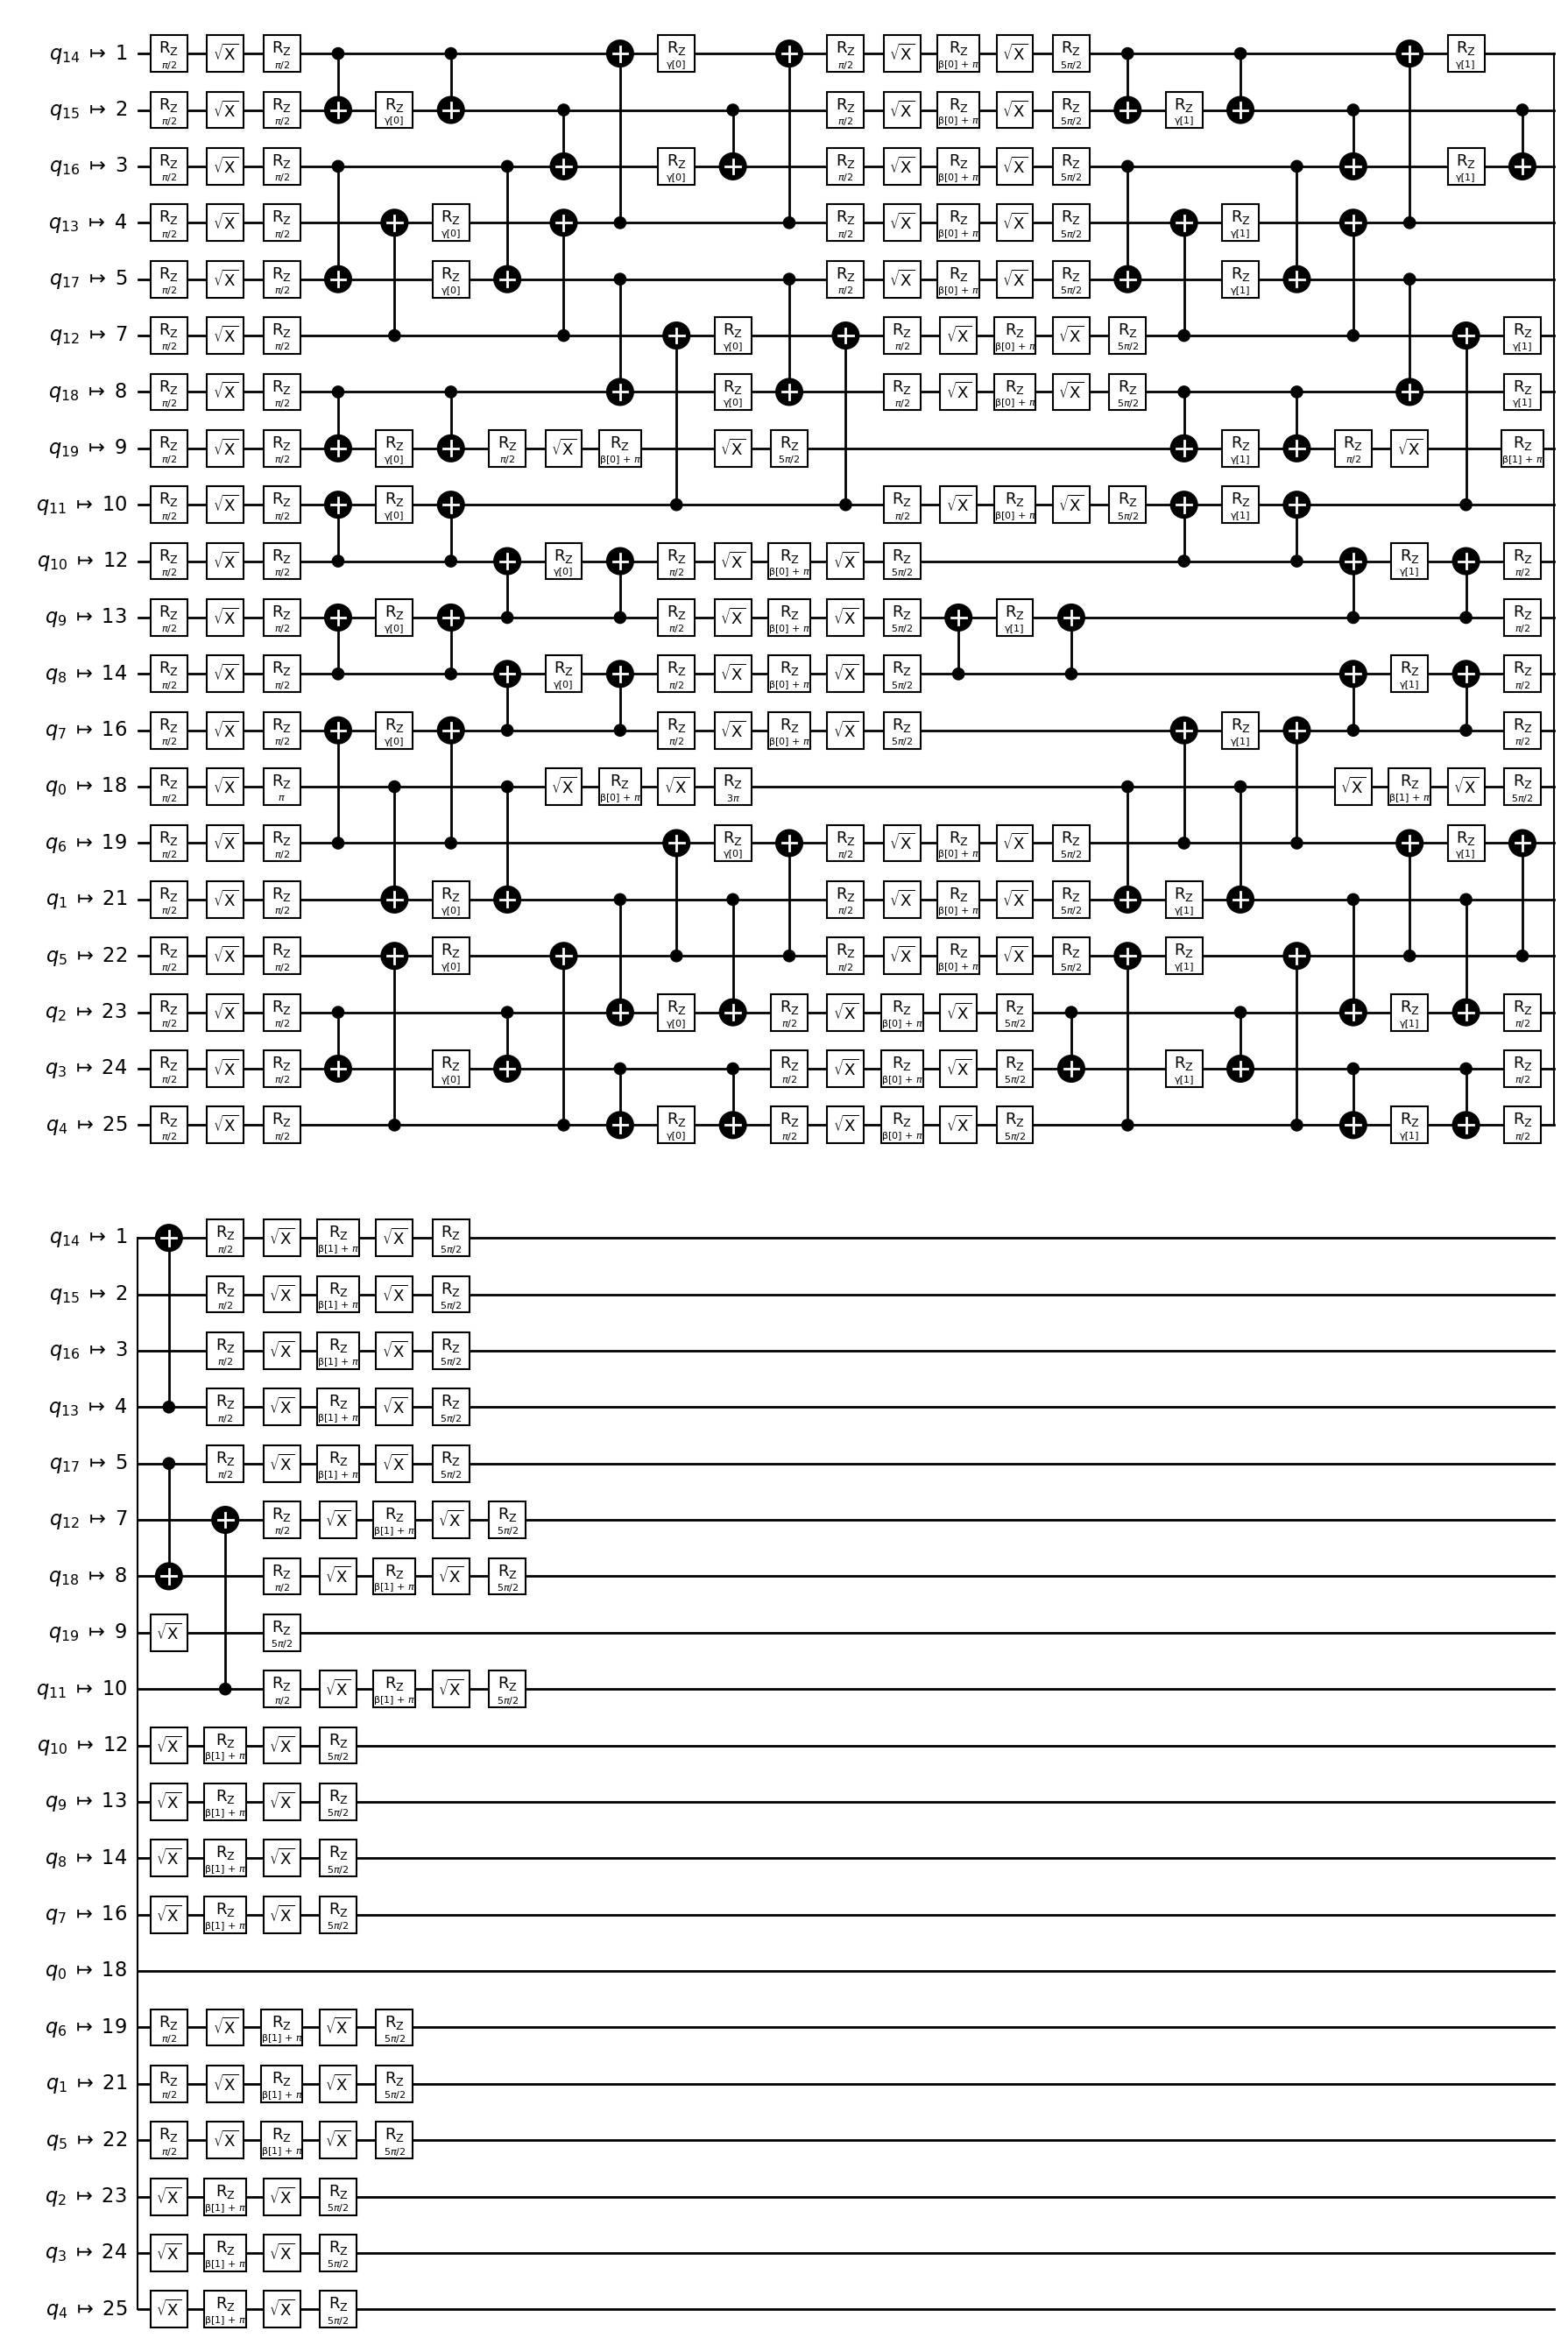

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
trans_qaoa = pm.run(qaoa)
trans_qaoa.draw('mpl',style='bw',idle_wires=False)

Note that when the circuit is transpiled, it is possible that the ordering of the qubits are changed due to qubit selection, or insertion of swap gates. It is necessary to permute the observables to conform to this transpiled ordering of qubits.

First we find out the final qubit indexing after transpilation

In [7]:
final_layout = trans_qaoa.layout.final_index_layout()
final_layout

[18, 21, 23, 24, 25, 22, 19, 16, 14, 13, 12, 10, 7, 4, 1, 2, 3, 5, 8, 9]

Now we can permute the observable according to this layout. Note that the observables are now stretched to conform to the number of qubits in the backend, and the Z operators are permuted to match the final layout after placement.

In [8]:
trans_obs = observable.apply_layout(final_layout, num_qubits=backend.num_qubits)
trans_obs

SparsePauliOp(['IIIIIIIIIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIIIIIIIZIIZIIII', 'IIIIIIIIIIIIIIIIZIIZIIIIIII', 'IIIIIIIIIIIIIIZIZIIIIIIIIII', 'IIIIIIIIIIIIIZZIIIIIIIIIIII', 'IIIIIIIIIIIIZZIIIIIIIIIIIII', 'IIIIIIIIIIZIZIIIIIIIIIIIIII', 'IIIIIIIZIIZIIIIIIIIIIIIIIII', 'IIIIZIIZIIIIIIIIIIIIIIIIIII', 'IZIIZIIIIIIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIZIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])

#### Now to run the optimization

Note that the number of optimization loops can be significantly high for a 20-qubit QAOA. Therefore, we shall truncate the number of loops to 10, both for cut and uncut, for brevity.

P.S. In order to run the entire optimization process, the user should remove <b>options={'maxiter':10}</b> from the code below.

In [9]:
def calculate_expval(params, circuit, estimator, observable):
    if circuit.num_clbits == 0:
        circuit.measure_all()

    circuit = circuit.assign_parameters(params)

    expval = estimator.run(circuit, observable).result().values[0]

    return expval

In [10]:
with Session(backend=backend):
    estimator = Estimator(options=options)
    res = minimize(
        calculate_expval, init_params, args=(trans_qaoa.copy(),estimator,trans_obs), method="cobyla", options={'maxiter':10}
    )

In [11]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -5.1045
       x: [-3.622e+00  3.718e-01 -1.849e+00 -2.152e+00]
    nfev: 10
   maxcv: 0.0

### Optimize

Now we leverage circuit cutting to improve the performance of QAOA.

#### 1. Cut the circuit into smaller subcircuits

First we cut the circuit into smaller subcircuits. For this example, we stick to only 2 subcircuits. However, it is possible to partition the circuit into more subcircuits as well. In order to cut the circuit, we use the <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html">Circuit Knitting Toolbox</a> from Qiskit Ecosystem. In particular, for this notebook we shall use the CutQc method to automatically find the cut location [2].

Before running this notebook, it is necessary to install the Circuit Knitting Toolbox. Guide for installation of this package is provided <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html">here</a>. The installation also includes the free version of CPLEX which is required for the automated cut finding used below. For bigger circuits, involving many cuts, the free version of CPLEX may not be sufficient.

Here we assign the maximum number of subcircuits to 2, and the maximum width of each subcircuit is set to num_qubits/2 + 2, i.e., each subcircuit should be roughly equal in size. The authors can refer to the <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/cutqc/tutorials/tutorial_1_automatic_cut_finding.html">How-to guides</a> on Circuit Knitting Toolbox for more information on this.

We shall also use the transpiled circuit template <i>trans_qaoa</i> for cutting so that the subcircuits are inherently transpiled.

In [66]:
from math import ceil
from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=qaoa,
    method="automatic",
    max_subcircuit_width=ceil(qaoa.num_qubits/2) + 2,
    max_cuts=3,
    num_subcircuits=[2],
    verbose=False
)

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 3 times.
MIP Presolve eliminated 37 rows and 8 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 271 substitutions.
Reduced MIP has 1086 rows, 367 columns, and 3167 nonzeros.
Reduced MIP has 361 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (5.37 ticks)
Probing time = 0.00 sec. (2.83 ticks)
Cover probing fixed 0 vars, tightened 2 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 106 columns.
Reduced MIP has 1086 rows, 261 columns, and 3167 nonzeros.
Reduced MIP has 255 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.00 ticks)
Probing time = 0.00 sec. (2.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 

##### We can check the two subcircuits produced by this method, and note that each of them have fewer qubit and gate count. Therefore, each subcircuit is expected to be less amenable to noise than the original circuit.

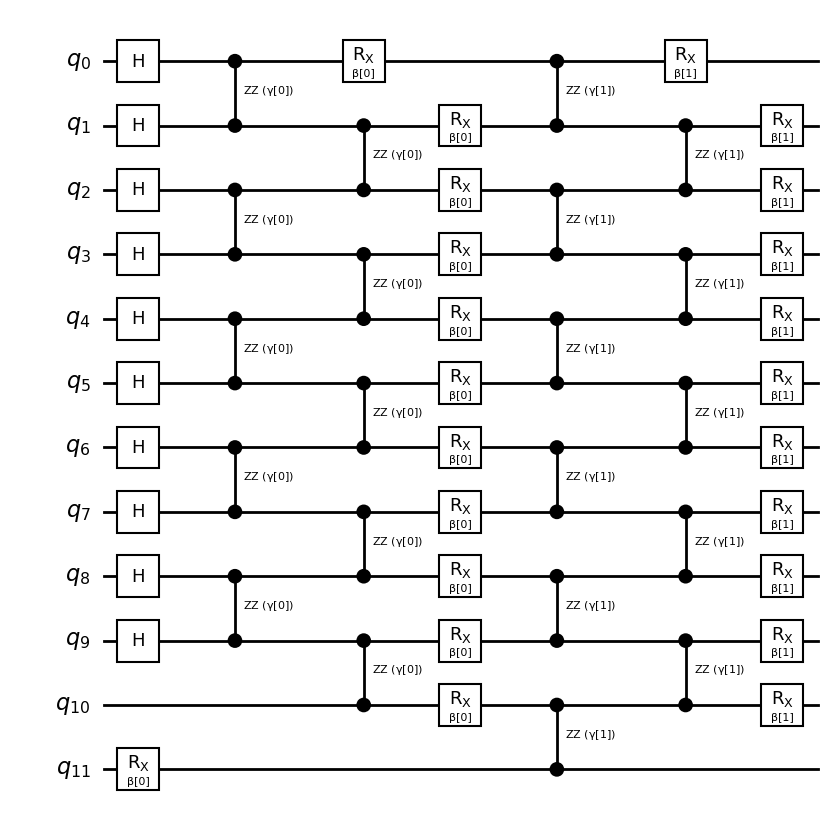

In [67]:
cuts['subcircuits'][0].draw('mpl',style='bw')

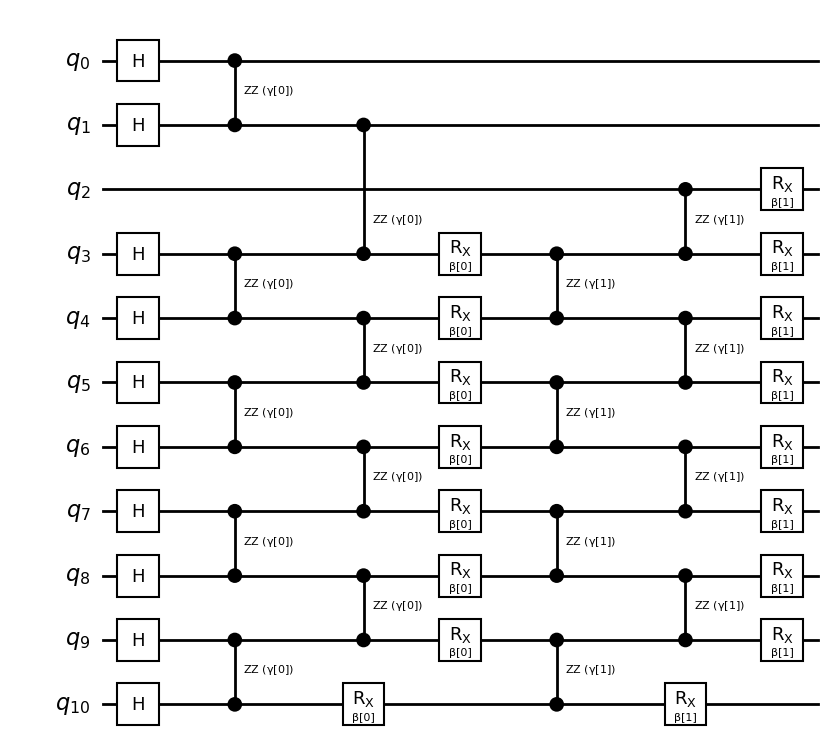

In [68]:
cuts['subcircuits'][1].draw('mpl',style='bw')

#### 2. Optimizing the overhead of cutting

Note that QAOA, and similar variational algorithms, execute the same circuit template multiple times with updated parameters till convergence. Since the cut depends on the structure of the circuit, and not on the parameter values, we can cut the template circuit <b>only once</b>, and update the parameters in every instance. The reconstruction, nevertheless, needs to be performed for each instance since the outcome depends on the parameter values.

First we shall transpile the two subcircuits in order to avoid doing so in every step of the QAOA optimization.

In [69]:
cuts['subcircuits'][0] = pm.run(cuts['subcircuits'][0])
cuts['subcircuits'][1] = pm.run(cuts['subcircuits'][1])

Since we have partitioned the template circuit, it is necessary to keep a track of which parameter is in which subcircuit. For this particular example, there are in total 4 parameters in the original circuit, and all of them are in both subcircuits. However, for general cases, this may not be the scenario.

In [70]:
params_ckt0 = list(cuts['subcircuits'][0].parameters)
params_ckt1 = list(cuts['subcircuits'][1].parameters)

In [71]:
print("Parameters in the 1st subcircuit are ",list(params_ckt0))
print("Parameters in the 2nd subcircuit are ",list(params_ckt1))

Parameters in the 1st subcircuit are  [ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])]
Parameters in the 2nd subcircuit are  [ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])]


### Run and postprocess

Now, we run the QAOA algorithm with circuit cutting. Note that each of the two subcircuits is executed independently, and the results from them are combined classically. In this notebook, we use the same hardware to run both the subcircuits sequentially. However, they can be executed on two different hardware, thus parallelizing the process [6,7].

Note that, in this approach the two distributions are combined classically, and not two expectation values. Therefore, for this approach, we shall use the sampler, and manually calculate the expectation value from the count distribution as a postprocessing step.

In [72]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits
from circuit_knitting.cutting.cutqc import reconstruct_full_distribution
from qiskit.result import sampled_expectation_value

def calculate_cut_expval(params, circuit, cuts, service, options, observable):
    cuts['subcircuits'][0].assign_parameters(params, inplace=True)
    cuts['subcircuits'][1].assign_parameters(params, inplace=True)

    subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
                                                             service=service,
                                                             backend_names=['ibm_auckland']*2,
                                                             options=options,
                                                            )
    reconstructed_probabilities = reconstruct_full_distribution(
        circuit, subcircuit_instance_probabilities, cuts
    )

    prob_dict = {}

    for idx, prob in enumerate(reconstructed_probabilities):
        prob_dict[bin(idx)[2:].zfill(circuit.num_qubits)] = prob

    expval = sampled_expectation_value(prob_dict, observable)

    return expval

Note that we need to pass the transpiled observable <i>trans_obs</i>, and the copy of the <i>cuts</i> dictionary. This is necessary because the original <i>cuts</i> dictionary contains template circuits, and during execution actual parameter values will be assigned. The original template needs to be retained to ensure seamless assignment of parameter in every loop of optimization.

In [73]:
res = minimize(
    calculate_cut_expval, init_params, args=(trans_qaoa, cuts.copy(), service, options, trans_obs), method="cobyla", options={'maxiter':10}
)

ValueError: Qubit(QuantumRegister(12, 'q'), 10) is not in list

In [18]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -6.292421124586673
       x: [-3.778e+00 -2.192e-01 -2.178e+00 -2.589e+00]
    nfev: 10
   maxcv: 0.0

### Inference

Recall that the observable was selected from the Max-Cut problem, and lower the value of the objective function, the better it is. We observe that after 10 steps of iteration, the uncut QAOA reached an objective function of -4.9565 whereas the cut QAOA reached -6.2924. This shows that cutting itself can suppress the effect of noise.

Note that it is possible to use other error suppression and mitigation methods together with circuit cutting to further improve the performance. Moreover, in this notebook, we computed both the subcircuits on the same hardware. In [7], the authors shows a method to distribute the subcircuits on different hardware using noise information in order to maximize the noise suppression, and parallelize the process.

<b>Word of caution</b>

The postprocessing time scales exponentially with the number of cuts. Therefore, while many cuts can produce small subcircuits, thus further improving the performance, it also leads to a significantly high postprocessing time, which may not be practical for most cases. Therefore, circuit cutting should be used only when the number of cuts is small.

<b>References</b>

<ol>
  <li>Peng, T., Harrow, A. W., Ozols, M., & Wu, X. (2020). Simulating large quantum circuits on a small quantum computer. Physical review letters, 125(15), 150504.</li>
  <li>Tang, W., Tomesh, T., Suchara, M., Larson, J., & Martonosi, M. (2021, April). Cutqc: using small quantum computers for large quantum circuit evaluations. In Proceedings of the 26th ACM International conference on architectural support for programming languages and operating systems (pp. 473-486).</li>
  <li>Perlin, M. A., Saleem, Z. H., Suchara, M., & Osborn, J. C. (2021). Quantum circuit cutting with maximum-likelihood tomography. npj Quantum Information, 7(1), 64.</li>
  <li>Majumdar, R., & Wood, C. J. (2022). Error mitigated quantum circuit cutting. arXiv preprint arXiv:2211.13431.</li>
  <li>Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.</li>
  <li>Khare, T., Majumdar, R., Sangle, R., Ray, A., Seshadri, P. V., & Simmhan, Y. (2023). Parallelizing Quantum-Classical Workloads: Profiling the Impact of Splitting Techniques. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 990-1000). IEEE.</li>
  <li>Bhoumik, D., Majumdar, R., Saha, A., & Sur-Kolay, S. (2023). Distributed Scheduling of Quantum Circuits with Noise and Time Optimization. arXiv preprint arXiv:2309.06005.</li>
</ol>

In [74]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

ModuleNotFoundError: No module named 'qiskit.tools'